In [1]:
from utility.clean_data_func import clean_and_filter_data
import re

def remove_special_characters(text):
    """Removes special characters from a text string."""
    pattern = r"[^\w\s]"  # Keep alphanumeric characters and whitespace
    return re.sub(pattern, "", text)


def lowercase(text):
    """Converts a text string to lowercase."""
    return text.lower()


# Clean data
print("Clean data")
df = clean_and_filter_data("./utility/azarbeijan-reviews.csv")
df["content"] = df["content"].apply(remove_special_characters)
df["content"] = df["content"].apply(lowercase)

Clean data
                                             content  score  upvotes
0                                          Çox qəşəy      5        0
1  Men niye nomre ile qeydiyatdan kece bilmirem.....      1        0
2  Salam. Mən yukluyə bilmirəm. Necə kömək edə bi...      5        0
3                                          cox gözəl      5        1
4  Xaiş edirem bu problemi hell edinde həftədə 2 ...      5        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127537 entries, 0 to 127536
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  127534 non-null  object
 1   score    127537 non-null  int64 
 2   upvotes  127537 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ MB
None
content    3
score      0
upvotes    0
dtype: int64


In [2]:
from gensim.models import FastText
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /Users/hasaneke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Assuming 'df' is your DataFrame and 'content' is the column with text data
sentences = [word_tokenize(text) for text in df['content'].values]

In [4]:
model = FastText(sentences, vector_size=100, window=3, min_count=1, workers=4, epochs=10)

In [5]:
# Example: Get the vector for the word 'sample'
vector = model.wv['sample']  # This will generate a vector for 'sample'

In [6]:
import numpy as np
# Function to create an average vector for a sentence
def sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv]
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

# Create feature vectors for each sentence in the dataset
features = np.array([sentence_vector(sentence, model) for sentence in sentences])

In [7]:
import numpy as np

# Assume df['score'] exists and contains integer ratings from 1 to 5
# Define positive sentiment for scores 4 and 5, and negative for scores 1, 2, and 3
labels = np.array([1 if score >= 4 else 0 for score in df['score']])


In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train,y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [9]:
model = tf.keras.Sequential([
tf.keras.layers.Dense(64, activation='relu', input_dim=100), # Input dimension = 100 (vector_size of FastText)
tf.keras.layers.Dense(32, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation='relu')
])

model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

/Users/hasaneke/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.7733 - loss: 1.5939 - val_accuracy: 0.8171 - val_loss: 0.4462
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.8250 - loss: 0.4640 - val_accuracy: 0.8081 - val_loss: 0.4423
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.8110 - loss: 0.4581 - val_accuracy: 0.8070 - val_loss: 0.4368
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.8190 - loss: 0.4443 - val_accuracy: 0.7994 - val_loss: 0.4342
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.8220 - loss: 0.4295 - val_accuracy: 0.8254 - val_loss: 0.4286
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.8117 - loss: 0.4403 - val_accuracy: 0.8254 - val_loss: 0.4233
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.8005 - loss: 0.5289 - val_accuracy: 0.8153 - val_loss: 0.4322
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.8239 - loss: 0.4334 - 

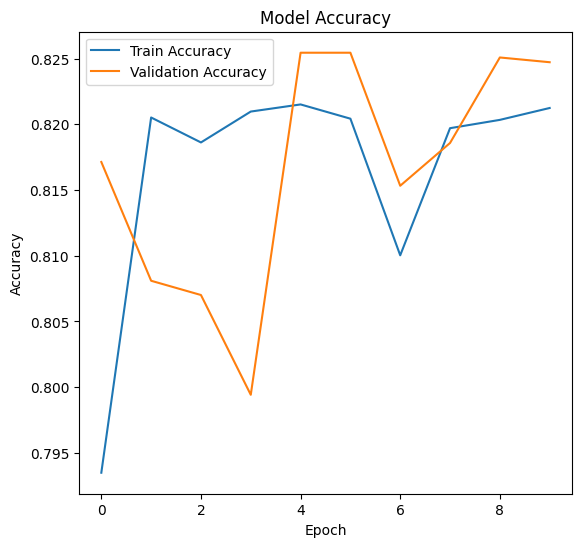

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

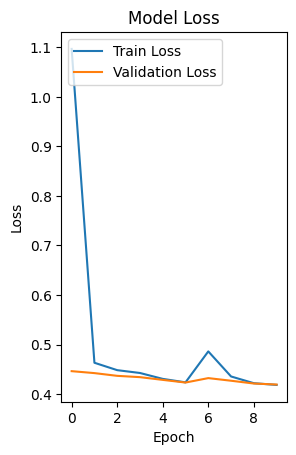

In [12]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()